# Терешенков БВТ2203. Лаб. работа №1. AE для удаления шума на датасете MNIST

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Класс автоэнкодера

In [3]:
class MNISTAutoEncoder(nn.Module):
    def __init__(self):
        super(MNISTAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
def add_noise(images, mean=0., std=0.1):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

In [10]:
def train_denoising_autoencoder(model, train_loader, optimizer, criterion, num_epochs=50):
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (data, _) in enumerate(train_loader):

            data = data.view(data.size(0), -1).to(device)  # [batch_size, 784]

            noisy_data = add_noise(data, std=0.7)
            optimizer.zero_grad()
            outputs = model(noisy_data)
            loss = criterion(outputs, data)

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}')
    
    return train_losses

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Mean and std for MNIST
])


In [12]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

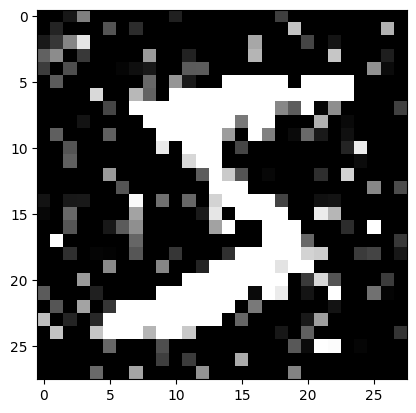

In [13]:
plt.imshow(add_noise(train_dataset[0][0], std=0.7).numpy().squeeze(), cmap="gray")

In [14]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
model = MNISTAutoEncoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
losses = train_denoising_autoencoder(model, train_loader, optimizer, criterion)

Epoch [1/50], Average Loss: 0.785269
Epoch [2/50], Average Loss: 0.698133
Epoch [3/50], Average Loss: 0.662220
Epoch [4/50], Average Loss: 0.646201
Epoch [5/50], Average Loss: 0.635984
Epoch [6/50], Average Loss: 0.625624
Epoch [7/50], Average Loss: 0.616519
Epoch [8/50], Average Loss: 0.610234
Epoch [9/50], Average Loss: 0.605428
Epoch [10/50], Average Loss: 0.601235
Epoch [11/50], Average Loss: 0.598397
Epoch [12/50], Average Loss: 0.595052
Epoch [13/50], Average Loss: 0.591770
Epoch [14/50], Average Loss: 0.589647
Epoch [15/50], Average Loss: 0.587778
Epoch [16/50], Average Loss: 0.586005
Epoch [17/50], Average Loss: 0.584460
Epoch [18/50], Average Loss: 0.582933
Epoch [19/50], Average Loss: 0.581710
Epoch [20/50], Average Loss: 0.580685
Epoch [21/50], Average Loss: 0.579317
Epoch [22/50], Average Loss: 0.578107
Epoch [23/50], Average Loss: 0.576842
Epoch [24/50], Average Loss: 0.575527
Epoch [25/50], Average Loss: 0.574545
Epoch [26/50], Average Loss: 0.573546
Epoch [27/50], Averag

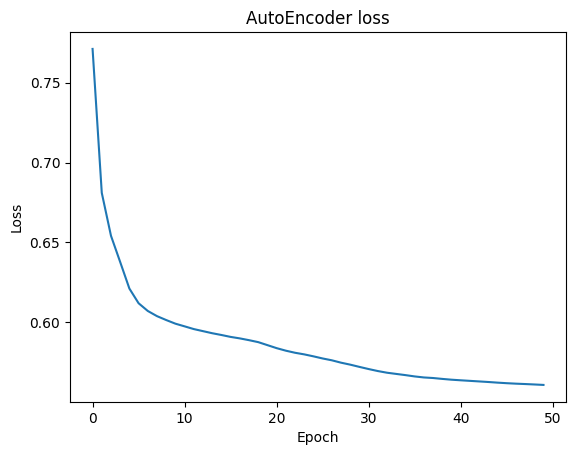

In [79]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("AutoEncoder loss")
plt.show()

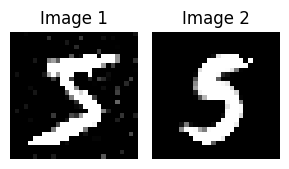

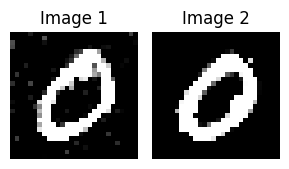

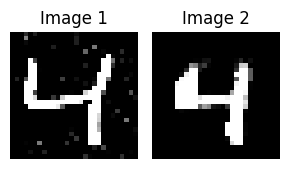

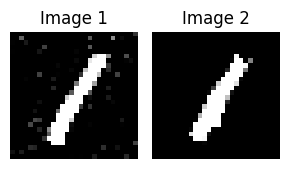

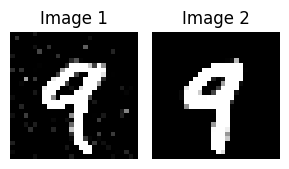

In [82]:
model.eval()

for i in range(5):
    noisy_img = add_noise(train_dataset[i][0], std=0.3)
    denoised_img = model.decoder(model.encoder(noisy_img.view(noisy_img.size(0), -1).to(device)))
    denoised_img = denoised_img.view(-1, 1, 28, 28).cpu()

    plt.figure(figsize=(3, 2))

    plt.subplot(1, 2, 1)
    plt.imshow(noisy_img.numpy().squeeze(), cmap="gray")
    plt.title('Image 1')
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.imshow(denoised_img.cpu().detach().numpy().squeeze(), "gray")
    plt.title('Image 2')
    plt.axis('off')

    plt.tight_layout()
